# Importation

In [1]:
# import dataiku # comment if not working in Dataiku
import pandas as pd
import numpy as np
if not hasattr(np, 'unicode_'):
    np.unicode_ = str
import ast
import os
import math
import plotly.express as px
import matplotlib.pyplot as plt
from typing import Dict, Tuple, List
from scipy.signal import chirp, find_peaks, peak_widths

In [2]:
cosmicai_path = 'Data' # replace with your data path, if not in Dataiku

df = pd.read_parquet(f'{cosmicai_path}/bandpass_qa0_no_partitions.parquet')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114354 entries, 0 to 114353
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   eb_uid               114354 non-null  object             
 1   cal_data_id          114354 non-null  object             
 2   cal_reduction_id     114354 non-null  object             
 3   start_valid_time     114354 non-null  datetime64[ns, UTC]
 4   receiver_band        114354 non-null  object             
 5   ref_antenna_name     114354 non-null  object             
 6   antenna              114354 non-null  object             
 7   polarization         114354 non-null  object             
 8   sideband             114354 non-null  object             
 9   baseband_name        114354 non-null  object             
 10  spw_name             114354 non-null  object             
 11  spw_name_ms          114354 non-null  object             
 12  fr

| N    |  Column Name             | Description   |              
| :--- | :----                    |          ---: |
| 0    | eb_uid              | Unique ID for one execution |
| 1    | cal_data_id         | Calibration Data ID  |             
| 2    | cal_reduction_id    | Calibration Reduction ID |
| 3    | start_valid_time    | Start Time for a bandpass observation |
| 4    | receiver_band       | ALMA Band used |
| 5    | ref_antenna_name    | Reference Antenna used for Bandpass calculation |       
| 6    | antenna             | Antenna for which the Bandpass solution is produced |
| 7    | polarization        | Reciever Polarization |
| 8    | sideband            | Reciever Sideband |
| 9    | baseband_name       | Baseband Name |
| 10   | spw_name            | Spectral Window Name |
| 11   | frequency_array     | Array with frequency dimension, Hz |
| 12   | amplitude_corr_tsys | Array with the amplitude dimension, corrected by Tsys (units?) |
| 13   | phase_norm_wrap     | Array with the phase dimension, normalized and wrapped, in radians |

In [4]:
df.head(10)

,eb_uid,cal_data_id,cal_reduction_id,start_valid_time,receiver_band,ref_antenna_name,antenna,polarization,sideband,baseband_name,spw_name,spw_name_ms,frequency_array,amplitude_corr_tsys,phase_norm_wrap
0,uid://A002/Xff45a6/X4435,CalData_7,CalReduction_7,2022-10-06 11:04:36.384000+00:00,ALMA_RB_07,DV21,DA41,X,LSB,BB_1,SpectralWindow_68,spw_25,"[351724225880.5871, 351708600880.5871, 3516929...","[0.014256122636602484, 0.014731913342933525, 0...","[-0.06451911942250001, -0.0617732094225, -0.00..."
1,uid://A002/Xff45a6/X4435,CalData_7,CalReduction_7,2022-10-06 11:04:36.384000+00:00,ALMA_RB_07,DV21,DA41,Y,LSB,BB_1,SpectralWindow_68,spw_25,"[351724225880.5871, 351708600880.5871, 3516929...","[0.013380656345701562, 0.014427262421258363, 0...","[-0.06347614638691666, -0.01566072838691667, -..."
2,uid://A002/Xff45a6/X4435,CalData_7,CalReduction_7,2022-10-06 11:04:36.384000+00:00,ALMA_RB_07,DV21,DA42,X,LSB,BB_1,SpectralWindow_68,spw_25,"[351724225880.5871, 351708600880.5871, 3516929...","[0.014431147004386208, 0.013925552020024039, 0...","[-0.2176890534425, -0.22305674344249998, -0.19..."
3,uid://A002/Xff45a6/X4435,CalData_7,CalReduction_7,2022-10-06 11:04:36.384000+00:00,ALMA_RB_07,DV21,DA42,Y,LSB,BB_1,SpectralWindow_68,spw_25,"[351724225880.5871, 351708600880.5871, 3516929...","[0.01401435387584803, 0.014249317856180726, 0....","[0.03815305532075, 0.06564197832074999, 0.0391..."
4,uid://A002/Xff45a6/X4435,CalData_7,CalReduction_7,2022-10-06 11:04:36.384000+00:00,ALMA_RB_07,DV21,DA43,X,LSB,BB_1,SpectralWindow_68,spw_25,"[351724225880.5871, 351708600880.5871, 3516929...","[0.014949316205388486, 0.015328749924888039, 0...","[-0.13109463273738334, -0.18370725273738334, -..."
5,uid://A002/Xff699e/X6974,CalData_4,CalReduction_4,2022-10-09 17:40:10.656000+00:00,ALMA_RB_04,CM01,CM06,X,USB,BB_3,SpectralWindow_19,spw_19,"[150871486373.90137, 150873439498.90137, 15087...","[0.024190828533784767, 0.0051622162668125545, ...","[0.6838406129344756, 0.05269995493447559, -0.2..."
6,uid://A002/Xff699e/X6974,CalData_4,CalReduction_4,2022-10-09 17:40:10.656000+00:00,ALMA_RB_04,CM01,CM06,Y,USB,BB_3,SpectralWindow_19,spw_19,"[150871486373.90137, 150873439498.90137, 15087...","[0.025927256615948486, 0.007084583343615775, 0...","[0.7255411565183203, 0.6957963965183204, 0.191..."
7,uid://A002/Xff699e/X6974,CalData_4,CalReduction_4,2022-10-09 17:40:10.656000+00:00,ALMA_RB_04,CM01,CM07,X,USB,BB_3,SpectralWindow_19,spw_19,"[150871486373.90137, 150873439498.90137, 15087...","[0.0, 0.006509686334499946, 0.0026469934814994...","[-0.31342649635728514, -0.2787113263572851, -0..."
8,uid://A002/Xff45a6/X4435,CalData_7,CalReduction_7,2022-10-06 11:04:36.384000+00:00,ALMA_RB_07,DV21,DA43,Y,LSB,BB_1,SpectralWindow_68,spw_25,"[351724225880.5871, 351708600880.5871, 3516929...","[0.01490487109608887, 0.01510182558336035, 0.0...","[-0.16930026337416668, -0.13606859337416666, -..."
9,uid://A002/Xff45a6/X4435,CalData_7,CalReduction_7,2022-10-06 11:04:36.384000+00:00,ALMA_RB_07,DV21,DA44,X,LSB,BB_1,SpectralWindow_68,spw_25,"[351724225880.5871, 351708600880.5871, 3516929...","[0.015536372678635918, 0.014857486677088527, 0...","[-0.21134714639021668, -0.26473911639021663, -..."


# Demonstration

In [ ]:
bandpass_sel_df = df.query('eb_uid == "uid://A002/Xff45a6/X4435"').copy()

In [ ]:
fig1 = px.scatter(
    x = bandpass_sel_df.iloc[0]['frequency_array'],
    y = bandpass_sel_df.iloc[0]['amplitude_corr_tsys'],
    render_mode='webgl', range_y=[0, 0.02], 
    labels={'x': 'Frequency [Hz]', 'y': 'Amplitude [?]'}
)
fig1

In [ ]:
fig1 = px.scatter(
    x = bandpass_sel_df.iloc[20]['frequency_array'],
    y = bandpass_sel_df.iloc[20]['phase_norm_wrap'],
    render_mode='webgl', range_y=[-np.pi, np.pi], 
    labels={'x': 'Frequency [Hz]', 'y': 'Phase [rad]'}
)
fig1

In [ ]:
bandpass_explode_df = bandpass_sel_df.explode(['frequency_array','amplitude_corr_tsys','phase_norm_wrap'])

bandpass_explode_df['label'] = bandpass_explode_df.apply(
    lambda x: f'{x["antenna"]}, {x["spw_name"]}, pol {x["polarization"]}', axis=1)

In [ ]:
fig2 = px.scatter(
    bandpass_explode_df,
    x='frequency_array', 
    y='amplitude_corr_tsys',
    color='label', render_mode='webgl',
)
fig2.update_traces(mode='lines', opacity=0.5)

In [ ]:
fig2 = px.line(
    bandpass_explode_df.query('antenna == ["DV24", "DA46", "DV09"] and spw_name == "SpectralWindow_68"'),
    x='frequency_array', 
    y='amplitude_corr_tsys',
    color='label', render_mode='webgl'
)
fig2

In [ ]:
fig2 = px.line(
    bandpass_explode_df.query('antenna == "DA64"'),
    x='frequency_array', 
    y='amplitude_corr_tsys',
    color='label', render_mode='webgl'
)
fig2

In [ ]:
fig2 = px.line(
    bandpass_explode_df.query('antenna == "DV09"'),
    x='frequency_array', 
    y='amplitude_corr_tsys',
    color='label', render_mode='webgl'
)
fig2

In [ ]:
fig2 = px.line(
    bandpass_explode_df.query('antenna == "DA59"'),
    x='frequency_array', 
    y='amplitude_corr_tsys',
    color='label', render_mode='webgl'
)
fig2

In [ ]:
fig2 = px.line(
    bandpass_explode_df.query('antenna == ["DA61", "DV03"]'),
    x='frequency_array', 
    y='phase_norm_wrap',
    color='label', render_mode='webgl'
)
fig2

# Data Analysis

In [ ]:
actual_specs = [np.array(x, dtype=float)
                 for x in df['amplitude_corr_tsys'].tolist()]

In [ ]:
freqs = [np.array(x, dtype=float)
                 for x in df['frequency_array'].tolist()]

In [ ]:
eb_uid = df['eb_uid']
antenna = df['antenna']
spw_name_ms = df['spw_name_ms']
polarization = df['polarization']

In [ ]:
length_groups: Dict[int, List[int]] = {}
for i, s in enumerate(actual_specs):
    L = s.shape[0]
    length_groups.setdefault(L, []).append(i)

In [ ]:
result: Dict[int, Tuple[np.ndarray, ...]] = {}
for L, idxs in length_groups.items():
    actual_specs_L = np.vstack([actual_specs[i] for i in idxs])
    freqs_L = np.vstack([freqs[i] for i in idxs])
    eb_uid_L = eb_uid[idxs]
    antenna_L = antenna[idxs]
    spw_name_ms_L = spw_name_ms[idxs]
    polarization_L = polarization[idxs]
    result[L] = (actual_specs_L, freqs_L, eb_uid_L, antenna_L, spw_name_ms_L, polarization_L)

In [ ]:
print(f"Found lengths: {sorted(result.keys())}")

In [ ]:
lengths, step_means, step_stds, span_means, span_stds = [], [], [], [], []
 
for length in sorted(result):
    actual_specs_L, freqs_L, eb_uid_L, antenna_L, spw_name_ms_L, polarization_L = result[length]
    print('Analyzing channel length of', length)
    lengths.extend(lengths)
    freq_step = abs(freqs_L[:, 1] - freqs_L[:, 0])
    freq_span = abs(freqs_L[:, -1] - freqs_L[:, 0])
    for name, arr in [("Step", freq_step),
                  ("Span", freq_span)]:
        print(f"--- {name} ---")
        print("  count:", arr.size)
        print("    mean:    ", np.mean(arr) / 10e6, "Mhz")
        print("    std:     ", np.std(arr) / 10e6, "Mhz")
        print("    min/max: ", np.min(arr) / 10e6, "Mhz", np.max(arr) / 10e6, "Mhz")
        print("    median:  ", np.median(arr) / 10e6, "Mhz")
        print("    25/75%:  ", np.percentile(arr, [25, 75]) / 10e6, "Mhz")
        print()

# Experimentation

In [ ]:
trans_df = pd.read_parquet(f'{cosmicai_path}/full_spectrum.gzip')

In [ ]:
df['frequency_array'] = df['frequency_array'] \
    .apply(lambda freqs: [f/1e9 for f in freqs])

In [ ]:
df['frequency_array']

In [ ]:
trans_freqs = trans_df['Frequency (GHz)'].values
trans_vals  = trans_df['Transmission (%)'].values

In [ ]:
def match_and_correct(freq_array):
    idxs = np.searchsorted(trans_freqs, freq_array)
    idxs[idxs == len(trans_freqs)] = len(trans_freqs) - 1
    left  = np.maximum(idxs - 1, 0)
    right = idxs
    dl = np.abs(freq_array - trans_freqs[left])
    dr = np.abs(trans_freqs[right] - freq_array)
    nearest = np.where(dl <= dr, left, right)
    mt = trans_vals[nearest]
    return mt

In [ ]:
results = df.apply(
    lambda row: match_and_correct(
        np.array(row['frequency_array'], dtype=float)
    ),
    axis=1
)

In [ ]:
df['transmission_array'] = results

In [ ]:
plt.figure(figsize=(100, 20))
plt.plot(trans_freqs, trans_vals, marker='o')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Transmission (%)')
plt.title('Transmission vs Frequency')
plt.grid(True)
plt.show()

In [ ]:
interference = []
for index in range(len(df)):
    freqs = np.array(df.iloc[index, 11])
    trans = np.array(df.iloc[index, 14])

    troguhs, props = find_peaks(-trans, prominence=1)
    widths_samples, _, left_ips, right_ips = peak_widths(-trans, troguhs, rel_height=0.75)

    left_freqs  = np.interp(left_ips,  np.arange(len(freqs)), freqs)
    right_freqs = np.interp(right_ips, np.arange(len(freqs)), freqs)
    widths_freq = right_freqs - left_freqs

    trough_freqs  = freqs[troguhs]
    trough_depths = props['prominences']

    trough_ranges = []
    for i in range(len(trough_freqs)):
        trough_ranges.append((trough_freqs[i] - widths_freq[i] / 2, trough_freqs[i] + widths_freq[i] / 2))

    trough_ranges = np.array(trough_ranges)

    closest_idxs = []

    for troguhs_range in trough_ranges:
        start, end = troguhs_range[0], troguhs_range[1]
        closest_start_idx = int(np.abs(freqs - start).argmin())
        closest_end_idx = int(np.abs(freqs - end).argmin())
        closest_idxs.append((closest_start_idx, closest_end_idx))

    interference.append(closest_idxs)

In [ ]:
index = 300
freqs = np.array(df.iloc[index, 11])
trans = np.array(df.iloc[index, 14])
# coeffs = np.polyfit(freqs, trans, 2)
# poly = np.poly1d(coeffs)
# fitted = poly(freqs)

plt.figure(figsize=(8,5))
plt.plot(range(len(freqs)), trans, 'o', label='Data')
# plt.plot(freqs, fitted, '-', label='Degree-3 fit')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Transmission (%)')
plt.title('Quadratic Fit to Transmission')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
peaks_df = pd.read_parquet(f'{cosmicai_path}/all_peaks_widths_heights.gzip')

In [ ]:
peaks  = peaks_df['Peaks (GHz)'].values
widths = peaks_df['Widths'].values
peak_ranges = np.column_stack((peaks - widths / 2, peaks + widths / 2))
peak_ranges_mid_points = np.array([float(start + end) / 2 for start, end in peak_ranges])

In [ ]:
freq_ranges = np.array([
    [float(min(x)), float(max(x))]
    for x in df['frequency_array'].tolist()
])
freq_ranges_mid_points = np.array([float(start + end) / 2 for start, end in freq_ranges])

In [ ]:
for idx, freq_points in enumerate(freq_ranges_mid_points):
    closest_idx = int(np.abs(peak_ranges_mid_points - freq_points).argmin())
    freqs = freq_ranges[idx]
    peaks = peak_ranges[closest_idx]
    start = max(freqs[0], peaks[0])
    end   = min(freqs[1], peaks[1])

In [ ]:
df['atmospheric_interference'] = interference

In [ ]:
df.to_csv(
    f'{cosmicai_path}/bandpass_augmented.csv',
    index=False
)

# Debugging

In [5]:
cosmicai_path = 'Data'

df_scored = pd.read_parquet(f'{cosmicai_path}/bandpass_qa0_no_partitions_labelled_filt_scored.parquet')

In [6]:
df_scored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55606 entries, 0 to 55605
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   eb_uid                    55606 non-null  object             
 1   cal_data_id               55606 non-null  object             
 2   cal_reduction_id          55606 non-null  object             
 3   start_valid_time          55606 non-null  datetime64[ns, UTC]
 4   receiver_band             55606 non-null  object             
 5   ref_antenna_name          55606 non-null  object             
 6   antenna                   55606 non-null  object             
 7   polarization              55606 non-null  object             
 8   sideband                  55606 non-null  object             
 9   baseband_name             55606 non-null  object             
 10  spw_name                  55606 non-null  object             
 11  spw_name_ms    

In [7]:
df_scored['win_span'] = ((df_scored['win_end'] - df_scored['win_start']).abs() * (df_scored['frequency_array'].str[1] - df_scored['frequency_array'].str[0])).abs()

In [8]:
df_scored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55606 entries, 0 to 55605
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   eb_uid                    55606 non-null  object             
 1   cal_data_id               55606 non-null  object             
 2   cal_reduction_id          55606 non-null  object             
 3   start_valid_time          55606 non-null  datetime64[ns, UTC]
 4   receiver_band             55606 non-null  object             
 5   ref_antenna_name          55606 non-null  object             
 6   antenna                   55606 non-null  object             
 7   polarization              55606 non-null  object             
 8   sideband                  55606 non-null  object             
 9   baseband_name             55606 non-null  object             
 10  spw_name                  55606 non-null  object             
 11  spw_name_ms    

In [9]:
df_scored_filtered_special = df_scored[df_scored['win_span'] == 31250000.0]

In [10]:
df_sorted_special = (
    df_scored_filtered_special
    .assign(freq_len = df_scored_filtered_special['frequency_array'].str.len())
    .sort_values(
        by=[ 'freq_len', 'score' ],
        ascending=[ True,    False ]
    )
    .drop(columns='freq_len')
    .reset_index(drop=True)
)

In [11]:
per_fig = 10
out_dir = 'Images/Special'
os.makedirs(out_dir, exist_ok=True)

KeyboardInterrupt: 

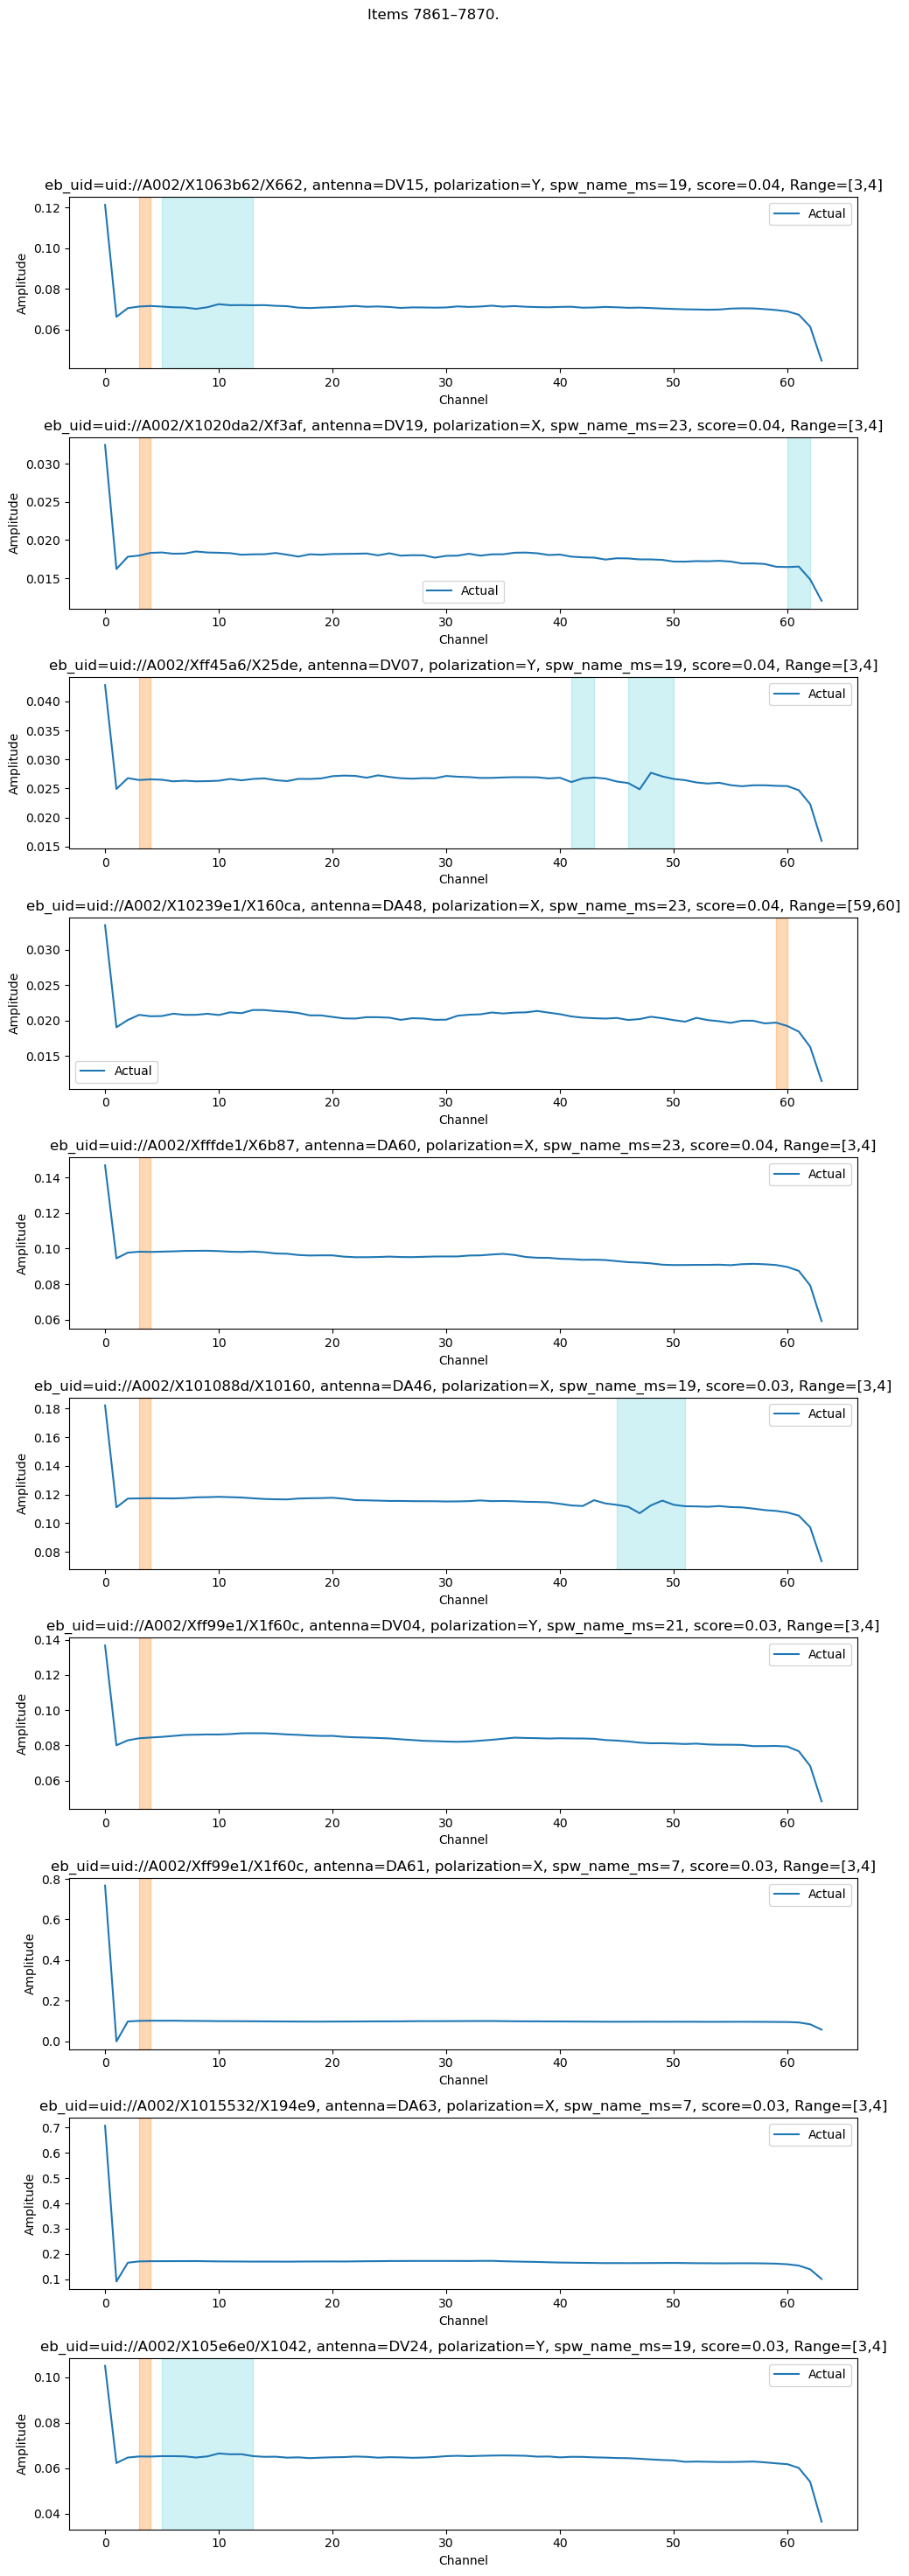

In [12]:
n_figs = math.ceil(len(df_sorted_special) / per_fig)
for fig_i in range(n_figs):
    chunk = df_sorted_special.iloc[fig_i*per_fig:(fig_i+1)*per_fig]
    fig_k = len(chunk)
    fig, axes = plt.subplots(fig_k, 1, figsize=(10, 3*fig_k))
    if fig_k == 1:
        axes = [axes]
    for ax, row in zip(axes, chunk.itertuples()):
        spec = row.amplitude_corr_tsys
        a, b = row.win_start, row.win_end
        atm_interfs = ast.literal_eval(row.atmospheric_interference)

        if len(atm_interfs) != 0:
            for item in atm_interfs:
                c, d = item[0], item[1]
                ax.axvspan(c, d, color='C9', alpha=0.2)

        x = np.arange(len(spec))
        ax.plot(x, spec, color='C0', label="Actual")

        ax.axvspan(a, b, color='C1', alpha=0.3)

        ax.set_title(
            f"eb_uid={row.eb_uid}, antenna={row.antenna}, polarization={row.polarization}, spw_name_ms={row.spw_name_ms}, score={row.score:.2f}, Range=[{a},{b}]"
        )
        ax.set_xlabel("Channel")
        ax.set_ylabel("Amplitude")
        ax.legend()
    plt.tight_layout(rect=[0,0,1,0.92])
    plt.suptitle(f"Items {fig_i*per_fig+1}–{fig_i*per_fig+fig_k}.", y=0.98)
    outpath = os.path.join(out_dir, f"fig{fig_i+1}.png")
    plt.savefig(outpath, dpi=500, bbox_inches="tight")
    plt.close(fig)